# Import

In [9]:
pip install tensorboardX

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from tensorboardX import SummaryWriter
import torchvision
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [39]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Define the size of the validation set
valid_size = 0.24
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Define data loaders for training, validation, and testing
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(train_idx))
val_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(valid_idx))
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Function to convert labels to one-hot encodings
def one_hot_encode(labels, num_classes):
    return torch.eye(num_classes)[labels]


# Sigmoid


In [46]:
class NeuralNetworkSig:
    def __init__(self, input_size, hidden_sizes, output_size):
        # Initialize network architecture
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_sizes) + 1

        # Initialize weights and biases for all layers
        self.w = [np.random.uniform(-self.calc_M(input_size, hidden_sizes[0]),
                                    self.calc_M(input_size, hidden_sizes[0]),
                                    (input_size, hidden_sizes[0]))]
        self.b = [np.zeros((1, hidden_sizes[0]))]
        for i in range(len(hidden_sizes) - 1):
            self.w.append(np.random.uniform(-self.calc_M(hidden_sizes[i], hidden_sizes[i+1]),
                                            self.calc_M(hidden_sizes[i], hidden_sizes[i+1]),
                                            (hidden_sizes[i], hidden_sizes[i+1])))
            self.b.append(np.zeros((1, hidden_sizes[i+1])))
        self.w.append(np.random.uniform(-self.calc_M(hidden_sizes[-1], output_size),
                                        self.calc_M(hidden_sizes[-1], output_size),
                                        (hidden_sizes[-1], output_size)))
        self.b.append(np.zeros((1, output_size)))
        self.total_loss = 0

    def calc_M(self, Ni, No):
        return np.sqrt(6 / (Ni + No))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))  # Subtracting the max for numerical stability
        return exp_x / exp_x.sum(axis=1, keepdims=True)

    def forward_pass(self, X):
        H = [X]
        for i in range(self.num_layers):
            z = np.dot(H[-1], self.w[i]) + self.b[i]
            if i == self.num_layers - 1:
                output = self.softmax(z)
                H.append(output)
            else:
                activation = self.sigmoid(z)
                H.append(activation)
        return H

    def cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-15  # Small constant to avoid log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        x = - y_true * np.log(y_pred)
        return np.sum(x, axis=1).mean()  # Calculate the mean loss

    def backward_pass(self, X, y_true, H):
        gradients = []
        g_a = H[-1] - y_true
        for i in range(self.num_layers - 1, -1, -1):
            if i == self.num_layers - 1:
                gw = np.dot(H[i].T, g_a)
                gb = np.sum(g_a, axis=0, keepdims=True)
            else:
                g_a = np.dot(g_a, self.w[i+1].T)
                g_a = g_a * H[i+1] * (1 - H[i+1])
                gw = np.dot(H[i].T, g_a)
                gb = np.sum(g_a, axis=0, keepdims=True)
            gradients.insert(0, (gw, gb))
        return gradients

    def update_weights(self, gradients, learning_rate):
        for i in range(self.num_layers):
            self.w[i] -= learning_rate * gradients[i][0]
            self.b[i] -= learning_rate * gradients[i][1]

    def train(self, X_batch, y_batch, learning_rate):
        total_loss = 0
        H = self.forward_pass(X_batch)
        loss = self.cross_entropy_loss(y_batch, H[-1])
        gradients = self.backward_pass(X_batch, y_batch, H)
        self.update_weights(gradients, learning_rate)
        self.total_loss += loss
        total_loss += loss
        average_loss = total_loss / len(X_batch)

    def validate(self, X_batch, y_batch):
        total_loss = 0
        H = self.forward_pass(X_batch)
        loss = self.cross_entropy_loss(y_batch, H[-1])
        self.total_loss += loss
        total_loss += loss
        average_loss = total_loss / len(X_batch)

    def predict(self, X):
        H = self.forward_pass(X)
        return np.argmax(H[-1], axis=1)


Epoch 1/15, Train Loss: 0.8546
Epoch 1/15, Test Loss: 0.3021
Epoch 2/15, Train Loss: 0.2822
Epoch 2/15, Test Loss: 0.2714
Epoch 3/15, Train Loss: 0.1985
Epoch 3/15, Test Loss: 0.1687
Epoch 4/15, Train Loss: 0.1509
Epoch 4/15, Test Loss: 0.1262
Epoch 5/15, Train Loss: 0.1257
Epoch 5/15, Test Loss: 0.1231
Epoch 6/15, Train Loss: 0.1039
Epoch 6/15, Test Loss: 0.1140
Epoch 7/15, Train Loss: 0.0884
Epoch 7/15, Test Loss: 0.0939
Epoch 8/15, Train Loss: 0.0760
Epoch 8/15, Test Loss: 0.0911
Epoch 9/15, Train Loss: 0.0684
Epoch 9/15, Test Loss: 0.0876
Epoch 10/15, Train Loss: 0.0591
Epoch 10/15, Test Loss: 0.1084
Epoch 11/15, Train Loss: 0.0502
Epoch 11/15, Test Loss: 0.0800
Epoch 12/15, Train Loss: 0.0443
Epoch 12/15, Test Loss: 0.0810
Epoch 13/15, Train Loss: 0.0396
Epoch 13/15, Test Loss: 0.0808
Epoch 14/15, Train Loss: 0.0412
Epoch 14/15, Test Loss: 0.0870
Epoch 15/15, Train Loss: 0.0285
Epoch 15/15, Test Loss: 0.0777
Test Accuracy: 97.65%


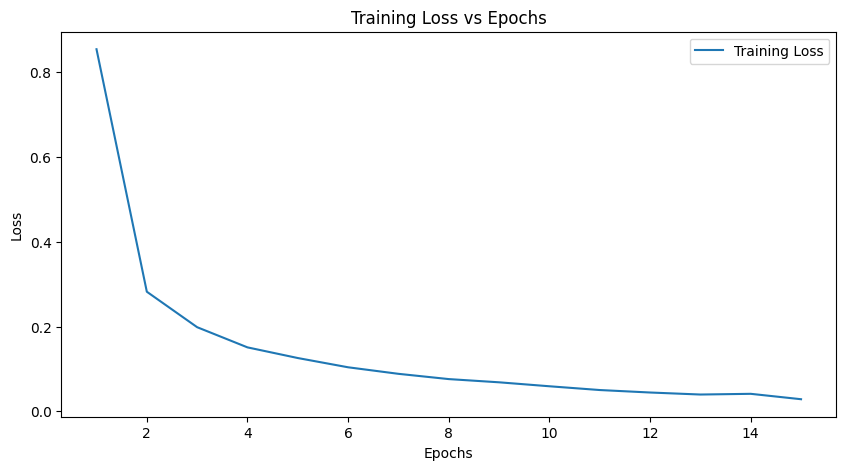

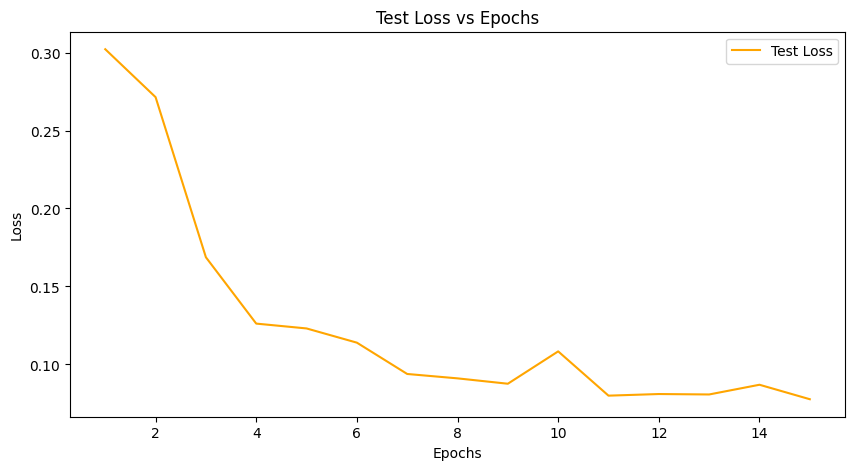

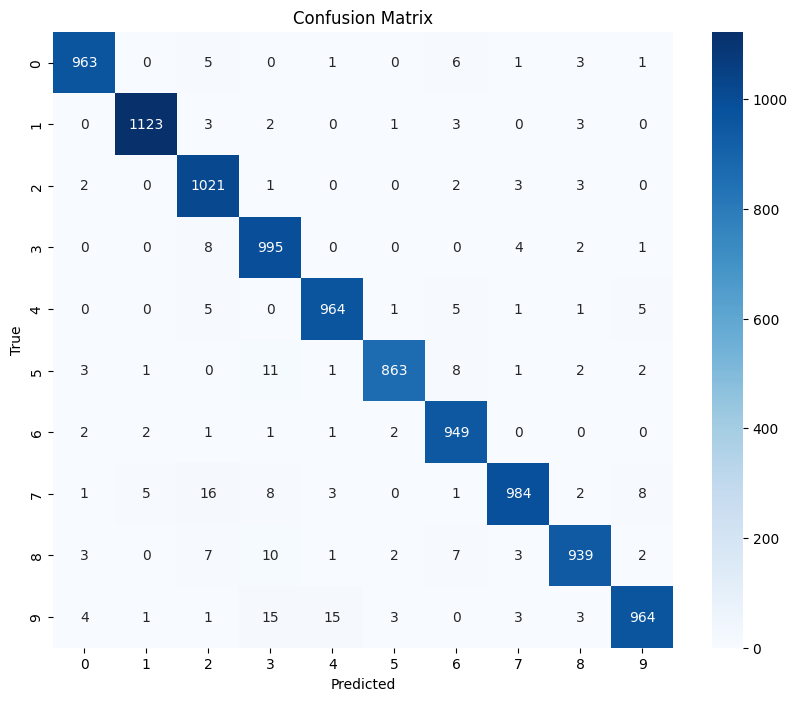

In [47]:
# Initialize the SummaryWriter
writer = SummaryWriter()

# Constants
input_size = 784
hidden_sizes = [500, 250, 100]
output_size = 10
learning_rate = 0.01
epochs = 15
train_losses = []
test_losses = []


# Create your NeuralNetwork model
model = NeuralNetworkSig(input_size, hidden_sizes, output_size)


# Training loop
for epoch in range(epochs):

    total_loss = 0

    for batch_images, batch_labels in train_loader:
        # Flatten the batch_images
        batch_images = batch_images.view(-1, input_size).numpy()
        # One-hot encode the batch_labels
        batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()
        # Train the model on the batch
        model.train(batch_images, batch_labels_onehot, learning_rate)

    average_loss = model.total_loss / len(train_loader)
    model.total_loss = 0
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {average_loss:.4f}")
    train_losses.append(average_loss)
    # Log the training loss to TensorBoard
    writer.add_scalar('Loss/Train', average_loss, epoch)

    # Test loop
    for batch_images, batch_labels in test_loader:
        batch_images = batch_images.view(-1, input_size).numpy()
        batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()
        # Get predictions from the model
        model.validate(batch_images,batch_labels_onehot)

    average_test_loss = model.total_loss / len(test_loader)
    model.total_loss = 0
    print(f"Epoch {epoch + 1}/{epochs}, Test Loss: {average_test_loss:.4f}")
    test_losses.append(average_test_loss)

    # Log the validation loss to TensorBoard
    writer.add_scalar('Loss/Test', average_test_loss, epoch)

# Close the SummaryWriter
writer.close()

# Testing loop
correct = 0
total = 0
true_labels = []
predicted_labels = []

for batch_images, batch_labels in test_loader:
    batch_images = batch_images.view(-1, input_size).numpy()
    batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()

    # Get predictions from the model
    predictions = model.predict(batch_images)

    # Calculate accuracy
    total += batch_labels.size(0)

    #print(total,predictions,batch_labels)
    correct += (predictions == batch_labels.numpy()).sum().item()
    true_labels.extend(batch_labels.numpy())
    predicted_labels.extend(predictions)

accuracy = (100 * correct / total)
print(f"Test Accuracy: {accuracy:.2f}%")
# Plot training and validation losses
epochs = range(1, epochs + 1)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()

# Plot test loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_losses, label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss vs Epochs')
plt.legend()
plt.show()
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# ReLu

In [48]:
class NeuralNetworkReLU:
    def __init__(self, input_size, hidden_sizes, output_size):
        # Initialize network architecture
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_sizes) + 1

        # Initialize weights and biases for all layers
        self.w = [np.random.uniform(-self.calc_M(input_size, hidden_sizes[0]),
                                    self.calc_M(input_size, hidden_sizes[0]),
                                    (input_size, hidden_sizes[0]))]
        self.b = [np.zeros((1, hidden_sizes[0]))]
        for i in range(len(hidden_sizes) - 1):
            self.w.append(np.random.uniform(-self.calc_M(hidden_sizes[i], hidden_sizes[i+1]),
                                            self.calc_M(hidden_sizes[i], hidden_sizes[i+1]),
                                            (hidden_sizes[i], hidden_sizes[i+1])))
            self.b.append(np.zeros((1, hidden_sizes[i+1])))
        self.w.append(np.random.uniform(-self.calc_M(hidden_sizes[-1], output_size),
                                        self.calc_M(hidden_sizes[-1], output_size),
                                        (hidden_sizes[-1], output_size)))
        self.b.append(np.zeros((1, output_size)))
        self.total_loss = 0

    def calc_M(self, Ni, No):
        return np.sqrt(6 / (Ni + No))

    def relu(self, x):
        return np.maximum(0, x)  # ReLU activation

    def softmax(self, x):
    # Subtract the maximum value for each row for numerical stability
        max_x = np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x - max_x)
        return exp_x / exp_x.sum(axis=1, keepdims=True)

    def forward_pass(self, X):
        H = [X]
        for i in range(self.num_layers):
            z = np.dot(H[-1], self.w[i]) + self.b[i]
            if i == self.num_layers - 1:
                output = self.softmax(z)
                H.append(output)
            else:
                activation = self.relu(z)  # ReLU activation
                H.append(activation)
        return H

    def cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-15  # Small constant to avoid log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        x = - y_true * np.log(y_pred)
        return np.sum(x, axis=1).mean()  # Calculate the mean loss

    def backward_pass(self, X, y_true, H):
        gradients = []
        g_a = H[-1] - y_true
        for i in range(self.num_layers - 1, -1, -1):
            if i == self.num_layers - 1:
                gw = np.dot(H[i].T, g_a)
                gb = np.sum(g_a, axis=0, keepdims=True)
            else:
                g_a = np.dot(g_a, self.w[i+1].T)
                g_a = g_a * (H[i+1] > 0).astype(int)  # Derivative of ReLU
                gw = np.dot(H[i].T, g_a)
                gb = np.sum(g_a, axis=0, keepdims=True)
            gradients.insert(0, (gw, gb))
        return gradients

    def update_weights(self, gradients, learning_rate):
        for i in range(self.num_layers):
            self.w[i] -= learning_rate * gradients[i][0]
            self.b[i] -= learning_rate * gradients[i][1]

    def train(self, X_batch, y_batch, learning_rate):
        total_loss = 0
        H = self.forward_pass(X_batch)
        loss = self.cross_entropy_loss(y_batch, H[-1])
        gradients = self.backward_pass(X_batch, y_batch, H)
        self.update_weights(gradients, learning_rate)
        self.total_loss += loss
        total_loss += loss
        average_loss = total_loss / len(X_batch)

    def validate(self, X_batch, y_batch):
        total_loss = 0
        H = self.forward_pass(X_batch)
        loss = self.cross_entropy_loss(y_batch, H[-1])
        self.total_loss += loss
        total_loss += loss
        average_loss = total_loss / len(X_batch)

    def predict(self, X):
        H = self.forward_pass(X)
        return np.argmax(H[-1], axis=1)


Epoch 1/15, Train Loss: 0.4096
Epoch 1/15, Test Loss: 0.1636
Epoch 2/15, Train Loss: 0.1614
Epoch 2/15, Test Loss: 0.1474
Epoch 3/15, Train Loss: 0.1133
Epoch 3/15, Test Loss: 0.1122
Epoch 4/15, Train Loss: 0.0879
Epoch 4/15, Test Loss: 0.0946
Epoch 5/15, Train Loss: 0.0707
Epoch 5/15, Test Loss: 0.0851
Epoch 6/15, Train Loss: 0.0579
Epoch 6/15, Test Loss: 0.0843
Epoch 7/15, Train Loss: 0.0474
Epoch 7/15, Test Loss: 0.0702
Epoch 8/15, Train Loss: 0.0395
Epoch 8/15, Test Loss: 0.0845
Epoch 9/15, Train Loss: 0.0316
Epoch 9/15, Test Loss: 0.0726
Epoch 10/15, Train Loss: 0.0269
Epoch 10/15, Test Loss: 0.0649
Epoch 11/15, Train Loss: 0.0209
Epoch 11/15, Test Loss: 0.0698
Epoch 12/15, Train Loss: 0.0185
Epoch 12/15, Test Loss: 0.0654
Epoch 13/15, Train Loss: 0.0147
Epoch 13/15, Test Loss: 0.0626
Epoch 14/15, Train Loss: 0.0106
Epoch 14/15, Test Loss: 0.0667
Epoch 15/15, Train Loss: 0.0099
Epoch 15/15, Test Loss: 0.0716
Test Accuracy: 98.01%


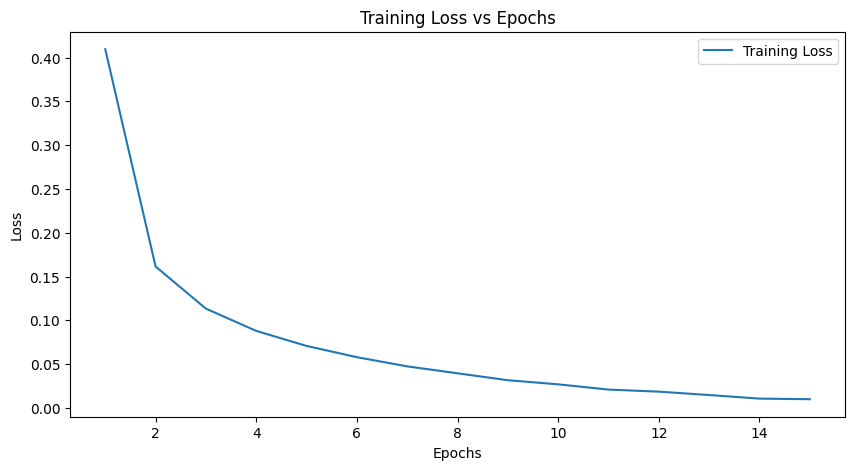

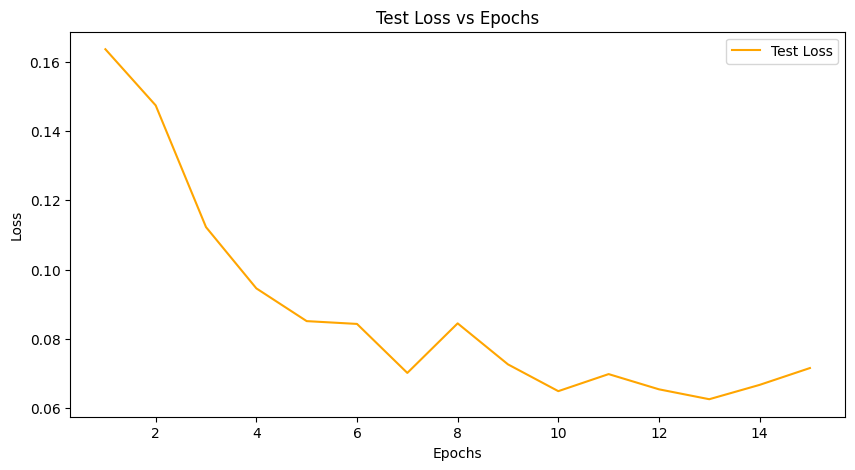

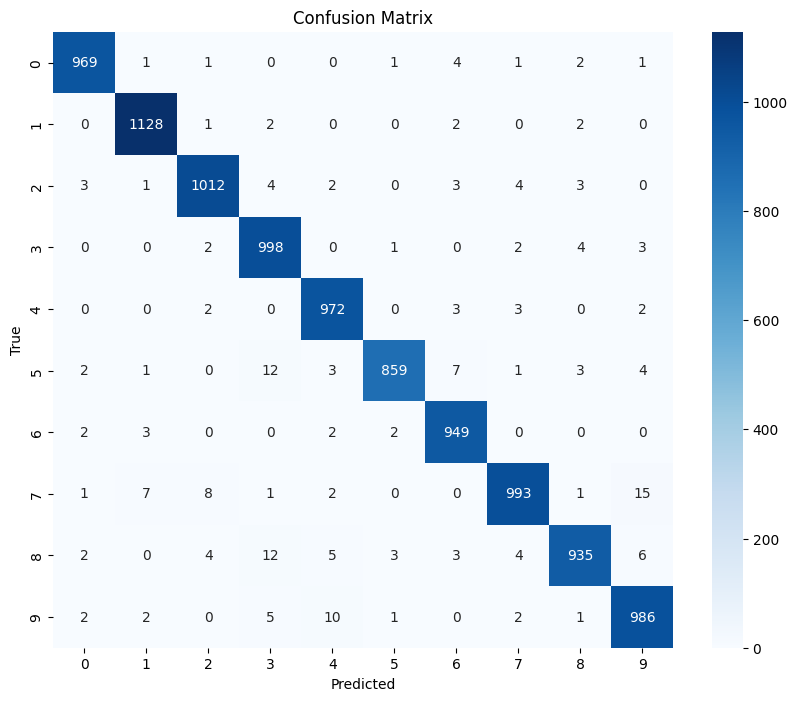

In [49]:
# Initialize the SummaryWriter
writer = SummaryWriter()

# Constants
input_size = 28 * 28
hidden_sizes = [500, 250, 100]
output_size = 10
learning_rate = 0.001
epochs = 15
train_losses = []
test_losses = []


# Create your NeuralNetwork model
model = NeuralNetworkReLU(input_size, hidden_sizes, output_size)


# Training loop
for epoch in range(epochs):

    total_loss = 0

    for batch_images, batch_labels in train_loader:
        # Flatten the batch_images
        batch_images = batch_images.view(-1, input_size).numpy()
        # One-hot encode the batch_labels
        batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()
        # Train the model on the batch
        model.train(batch_images, batch_labels_onehot, learning_rate)

    average_loss = model.total_loss / len(train_loader)
    model.total_loss = 0
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {average_loss:.4f}")
    train_losses.append(average_loss)
    # Log the training loss to TensorBoard
    writer.add_scalar('Loss/Train', average_loss, epoch)

    # Test loop
    for batch_images, batch_labels in test_loader:
        batch_images = batch_images.view(-1, input_size).numpy()
        batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()
        # Get predictions from the model
        model.validate(batch_images,batch_labels_onehot)

    average_test_loss = model.total_loss / len(test_loader)
    model.total_loss = 0
    print(f"Epoch {epoch + 1}/{epochs}, Test Loss: {average_test_loss:.4f}")
    test_losses.append(average_test_loss)

    # Log the validation loss to TensorBoard
    writer.add_scalar('Loss/Test', average_test_loss, epoch)

# Close the SummaryWriter
writer.close()

# Testing loop
correct = 0
total = 0
true_labels = []
predicted_labels = []

for batch_images, batch_labels in test_loader:
    batch_images = batch_images.view(-1, input_size).numpy()
    batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()

    # Get predictions from the model
    predictions = model.predict(batch_images)

    # Calculate accuracy
    total += batch_labels.size(0)

    #print(total,predictions,batch_labels)
    correct += (predictions == batch_labels.numpy()).sum().item()
    true_labels.extend(batch_labels.numpy())
    predicted_labels.extend(predictions)

accuracy = (100 * correct / total)
print(f"Test Accuracy: {accuracy:.2f}%")
# Plot training and validation losses
epochs = range(1, epochs + 1)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()

# Plot validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_losses, label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss vs Epochs')
plt.legend()
plt.show()
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# tanh

In [51]:
class NeuralNetworkTanh:
    def __init__(self, input_size, hidden_sizes, output_size):
        # Initialize network architecture
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_sizes) + 1

        # Initialize weights and biases for all layers
        self.w = [np.random.uniform(-self.calc_M(input_size, hidden_sizes[0]),
                                    self.calc_M(input_size, hidden_sizes[0]),
                                    (input_size, hidden_sizes[0]))]
        self.b = [np.zeros((1, hidden_sizes[0]))]
        for i in range(len(hidden_sizes) - 1):
            self.w.append(np.random.uniform(-self.calc_M(hidden_sizes[i], hidden_sizes[i+1]),
                                            self.calc_M(hidden_sizes[i], hidden_sizes[i+1]),
                                            (hidden_sizes[i], hidden_sizes[i+1])))
            self.b.append(np.zeros((1, hidden_sizes[i+1])))
        self.w.append(np.random.uniform(-self.calc_M(hidden_sizes[-1], output_size),
                                        self.calc_M(hidden_sizes[-1], output_size),
                                        (hidden_sizes[-1], output_size)))
        self.b.append(np.zeros((1, output_size)))
        self.total_loss = 0

    def calc_M(self, Ni, No):
        return np.sqrt(6 / (Ni + No))

    def tanh(self, x):
        return np.tanh(x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))  # Subtracting the max for numerical stability
        return exp_x / exp_x.sum(axis=1, keepdims=True)

    def forward_pass(self, X):
        H = [X]
        for i in range(self.num_layers):
            z = np.dot(H[-1], self.w[i]) + self.b[i]
            if i == self.num_layers - 1:
                output = self.softmax(z)
                H.append(output)
            else:
                activation = self.tanh(z)
                H.append(activation)
        return H

    def cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-15  # Small constant to avoid log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        x = - y_true * np.log(y_pred)
        return np.sum(x, axis=1).mean()  # Calculate the mean loss

    def backward_pass(self, X, y_true, H):
        gradients = []
        g_a = H[-1] - y_true
        for i in range(self.num_layers - 1, -1, -1):
            if i == self.num_layers - 1:
                gw = np.dot(H[i].T, g_a)
                gb = np.sum(g_a, axis=0, keepdims=True)
            else:
                g_a = np.dot(g_a, self.w[i+1].T)
                g_a = g_a * (1 - H[i+1]**2)  # Derivative of tanh
                gw = np.dot(H[i].T, g_a)
                gb = np.sum(g_a, axis=0, keepdims=True)
            gradients.insert(0, (gw, gb))
        return gradients

    def update_weights(self, gradients, learning_rate):
        for i in range(self.num_layers):
            self.w[i] -= learning_rate * gradients[i][0]
            self.b[i] -= learning_rate * gradients[i][1]

    def train(self, X_batch, y_batch, learning_rate):
        total_loss = 0
        H = self.forward_pass(X_batch)
        loss = self.cross_entropy_loss(y_batch, H[-1])
        gradients = self.backward_pass(X_batch, y_batch, H)
        self.update_weights(gradients, learning_rate)
        self.total_loss += loss
        total_loss += loss
        average_loss = total_loss / len(X_batch)

    def validate(self, X_batch, y_batch):
        total_loss = 0
        H = self.forward_pass(X_batch)
        loss = self.cross_entropy_loss(y_batch, H[-1])
        self.total_loss += loss
        total_loss += loss
        average_loss = total_loss / len(X_batch)

    def predict(self, X):
        H = self.forward_pass(X)
        return np.argmax(H[-1], axis=1)


Epoch 1/15, Train Loss: 0.6825
Epoch 1/15, Test Loss: 0.3860
Epoch 2/15, Train Loss: 0.3504
Epoch 2/15, Test Loss: 0.3042
Epoch 3/15, Train Loss: 0.2922
Epoch 3/15, Test Loss: 0.2785
Epoch 4/15, Train Loss: 0.2597
Epoch 4/15, Test Loss: 0.2453
Epoch 5/15, Train Loss: 0.2357
Epoch 5/15, Test Loss: 0.2306
Epoch 6/15, Train Loss: 0.2174
Epoch 6/15, Test Loss: 0.2111
Epoch 7/15, Train Loss: 0.2015
Epoch 7/15, Test Loss: 0.2010
Epoch 8/15, Train Loss: 0.1880
Epoch 8/15, Test Loss: 0.1862
Epoch 9/15, Train Loss: 0.1759
Epoch 9/15, Test Loss: 0.1789
Epoch 10/15, Train Loss: 0.1654
Epoch 10/15, Test Loss: 0.1713
Epoch 11/15, Train Loss: 0.1558
Epoch 11/15, Test Loss: 0.1612
Epoch 12/15, Train Loss: 0.1472
Epoch 12/15, Test Loss: 0.1532
Epoch 13/15, Train Loss: 0.1390
Epoch 13/15, Test Loss: 0.1488
Epoch 14/15, Train Loss: 0.1320
Epoch 14/15, Test Loss: 0.1434
Epoch 15/15, Train Loss: 0.1256
Epoch 15/15, Test Loss: 0.1392
Test Accuracy: 95.66%


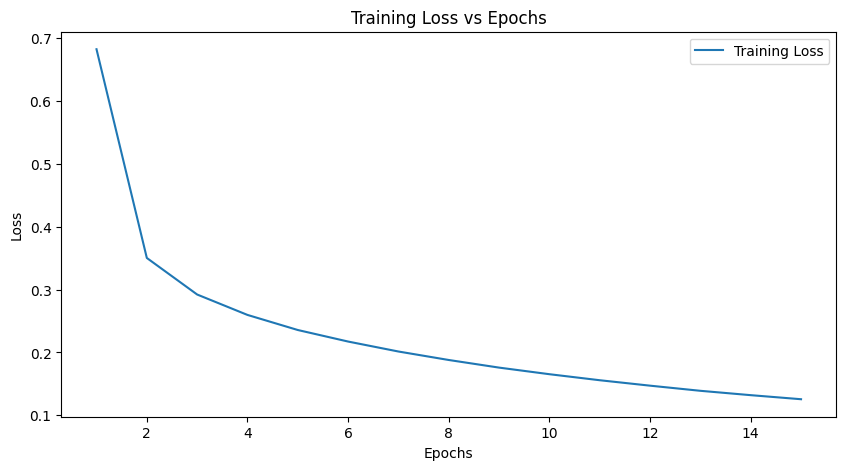

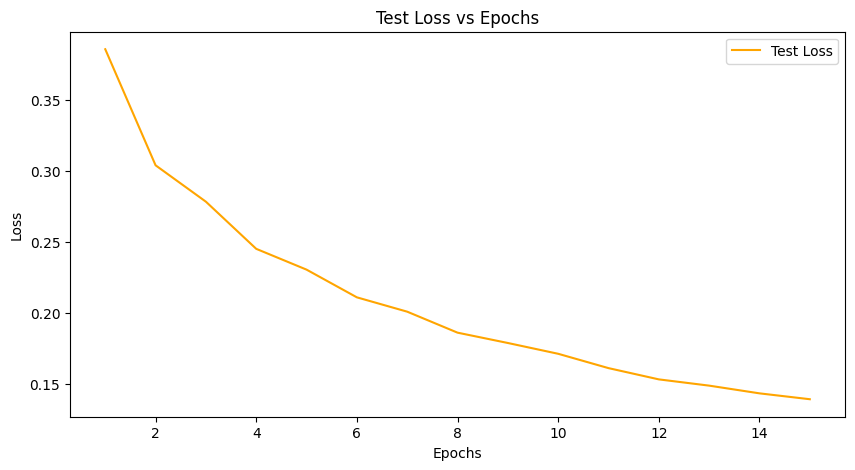

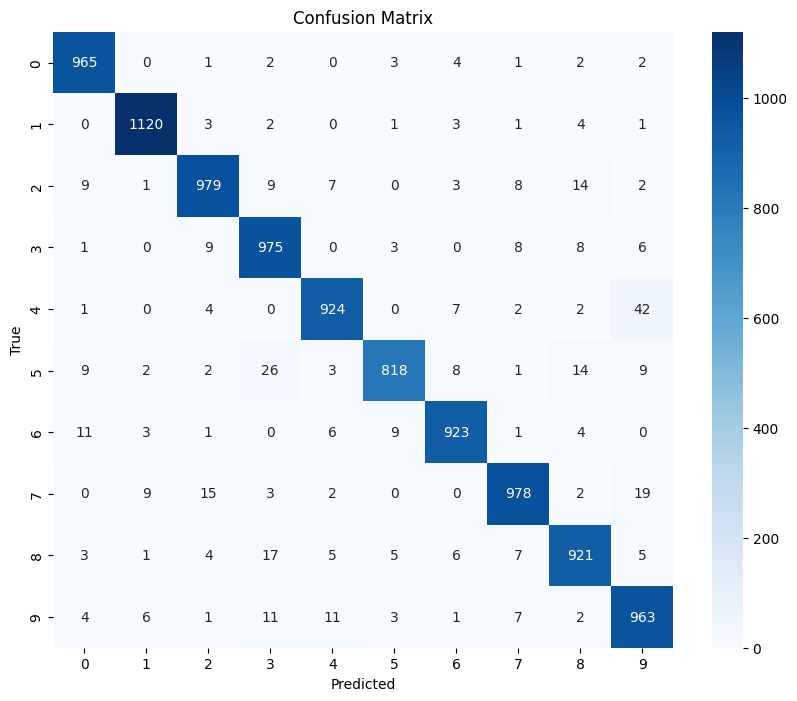

In [50]:
# Initialize the SummaryWriter
writer = SummaryWriter()

# Constants
input_size = 28 * 28
hidden_sizes = [500, 250, 100]
output_size = 10
learning_rate = 0.0001
epochs = 15
train_losses = []
test_losses = []


# Create your NeuralNetwork model
model = NeuralNetworkTanh(input_size, hidden_sizes, output_size)


# Training loop
for epoch in range(epochs):

    total_loss = 0

    for batch_images, batch_labels in train_loader:
        # Flatten the batch_images
        batch_images = batch_images.view(-1, input_size).numpy()
        # One-hot encode the batch_labels
        batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()
        # Train the model on the batch
        model.train(batch_images, batch_labels_onehot, learning_rate)

    average_loss = model.total_loss / len(train_loader)
    model.total_loss = 0
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {average_loss:.4f}")
    train_losses.append(average_loss)
    # Log the training loss to TensorBoard
    writer.add_scalar('Loss/Train', average_loss, epoch)

    # Test loop
    for batch_images, batch_labels in test_loader:
        batch_images = batch_images.view(-1, input_size).numpy()
        batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()
        # Get predictions from the model
        model.validate(batch_images,batch_labels_onehot)

    average_test_loss = model.total_loss / len(test_loader)
    model.total_loss = 0
    print(f"Epoch {epoch + 1}/{epochs}, Test Loss: {average_test_loss:.4f}")
    test_losses.append(average_test_loss)

    # Log the validation loss to TensorBoard
    writer.add_scalar('Loss/Test', average_test_loss, epoch)

# Close the SummaryWriter
writer.close()

# Testing loop
correct = 0
total = 0
true_labels = []
predicted_labels = []

for batch_images, batch_labels in test_loader:
    batch_images = batch_images.view(-1, input_size).numpy()
    batch_labels_onehot = one_hot_encode(batch_labels, output_size).numpy()

    # Get predictions from the model
    predictions = model.predict(batch_images)

    # Calculate accuracy
    total += batch_labels.size(0)

    #print(total,predictions,batch_labels)
    correct += (predictions == batch_labels.numpy()).sum().item()
    true_labels.extend(batch_labels.numpy())
    predicted_labels.extend(predictions)

accuracy = (100 * correct / total)
print(f"Test Accuracy: {accuracy:.2f}%")
# Plot training and validation losses
epochs = range(1, epochs + 1)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()

# Plot validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_losses, label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss vs Epochs')
plt.legend()
plt.show()
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Package

Epoch 1/15, Train Loss: 0.3733, Val Loss: 0.1920
Epoch 2/15, Train Loss: 0.1657, Val Loss: 0.1302
Epoch 3/15, Train Loss: 0.1226, Val Loss: 0.1210
Epoch 4/15, Train Loss: 0.0998, Val Loss: 0.1189
Epoch 5/15, Train Loss: 0.0837, Val Loss: 0.1134
Epoch 6/15, Train Loss: 0.0709, Val Loss: 0.0904
Epoch 7/15, Train Loss: 0.0646, Val Loss: 0.0894
Epoch 8/15, Train Loss: 0.0589, Val Loss: 0.1170
Epoch 9/15, Train Loss: 0.0536, Val Loss: 0.0838
Epoch 10/15, Train Loss: 0.0452, Val Loss: 0.0920
Epoch 11/15, Train Loss: 0.0433, Val Loss: 0.1131
Epoch 12/15, Train Loss: 0.0421, Val Loss: 0.0907
Epoch 13/15, Train Loss: 0.0374, Val Loss: 0.0962
Epoch 14/15, Train Loss: 0.0351, Val Loss: 0.0928
Epoch 15/15, Train Loss: 0.0333, Val Loss: 0.1133
Test Accuracy: 97.00%


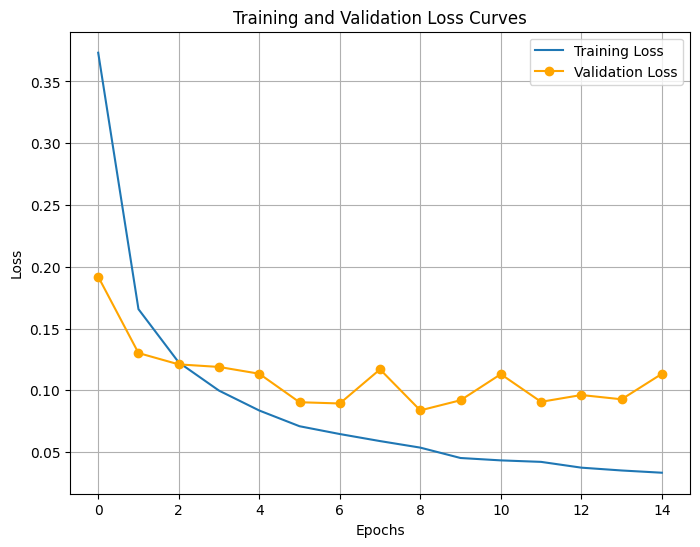

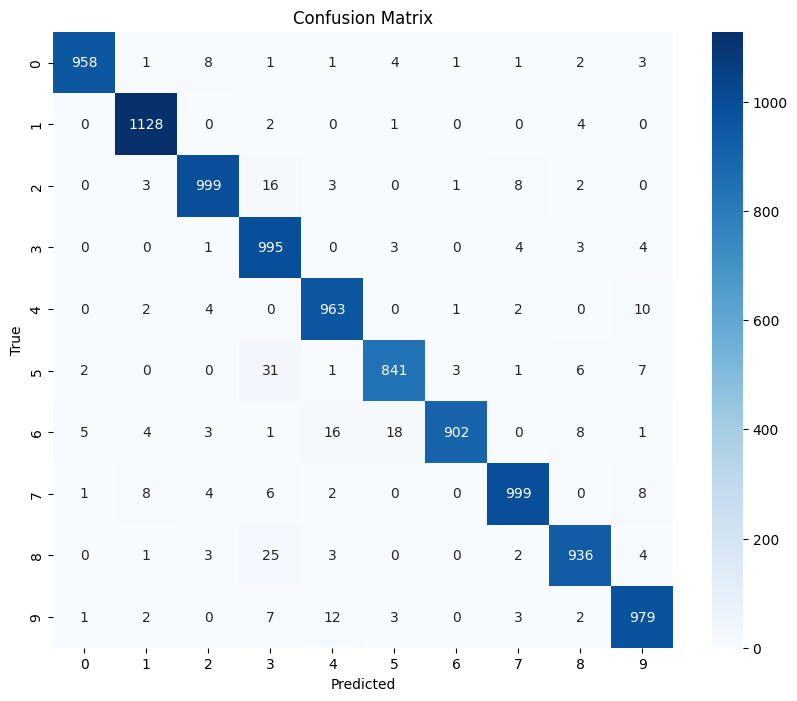

In [ ]:

# Define data transforms
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Define the size of the validation set
validation_size = 0.2  # Adjust as needed

# Create training and validation splits
num_samples = len(train_dataset)
indices = list(range(num_samples))
split = int(validation_size * num_samples)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Create data loaders for training, validation, and testing
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 500)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(500, 250)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(250, 100)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the neural network
model = NeuralNetwork()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 15
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

# Evaluate on the test set
model.eval()
correct = 0
total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Plot training and validation loss curves
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Advantages of Using Existing Libraries vs. Writing from Scratch:

**Efficiency**: Deep learning libraries like PyTorch are highly optimized and provide GPU support for faster computations.

**Abstraction**: Libraries offer high-level abstractions, simplifying model design and implementation.

**Community and Support**: Popular libraries have large user communities, extensive documentation, and community support.

**Flexibility**: Libraries allow researchers to experiment with custom models, loss functions, and training loops.

**Pretrained Models**: Libraries offer access to pretrained models, saving time and resources.

**Debugging Tools**: Libraries provide debugging tools and visualization capabilities for easier issue diagnosis and resolution.

Using existing libraries streamlines development, leverages community resources, and enables efficient experimentation with complex models.


# L2 Regularisation

Epoch 1/15, Train Loss: 0.4015
Epoch 1/15, Validation Loss: 0.2064
Epoch 2/15, Train Loss: 0.1719
Epoch 2/15, Validation Loss: 0.1619
Epoch 3/15, Train Loss: 0.1209
Epoch 3/15, Validation Loss: 0.1170
Epoch 4/15, Train Loss: 0.0971
Epoch 4/15, Validation Loss: 0.1150
Epoch 5/15, Train Loss: 0.0810
Epoch 5/15, Validation Loss: 0.1044
Epoch 6/15, Train Loss: 0.0700
Epoch 6/15, Validation Loss: 0.0979
Epoch 7/15, Train Loss: 0.0604
Epoch 7/15, Validation Loss: 0.0949
Epoch 8/15, Train Loss: 0.0523
Epoch 8/15, Validation Loss: 0.0906
Epoch 9/15, Train Loss: 0.0476
Epoch 9/15, Validation Loss: 0.0917
Epoch 10/15, Train Loss: 0.0409
Epoch 10/15, Validation Loss: 0.0980
Epoch 11/15, Train Loss: 0.0378
Epoch 11/15, Validation Loss: 0.0941
Epoch 12/15, Train Loss: 0.0352
Epoch 12/15, Validation Loss: 0.0950
Epoch 13/15, Train Loss: 0.0333
Epoch 13/15, Validation Loss: 0.0865
Epoch 14/15, Train Loss: 0.0289
Epoch 14/15, Validation Loss: 0.0917
Epoch 15/15, Train Loss: 0.0286
Epoch 15/15, Validat

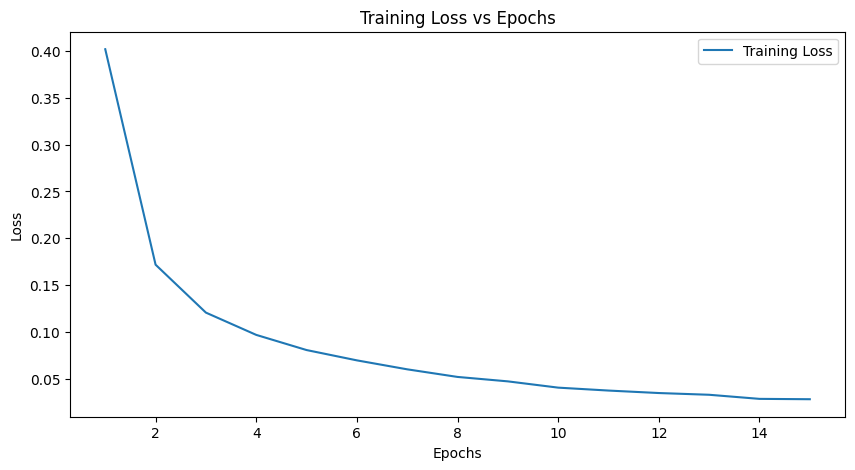

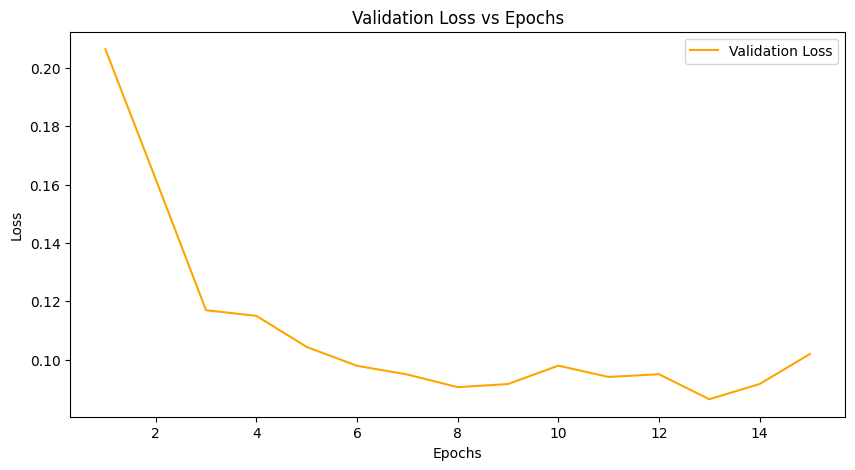

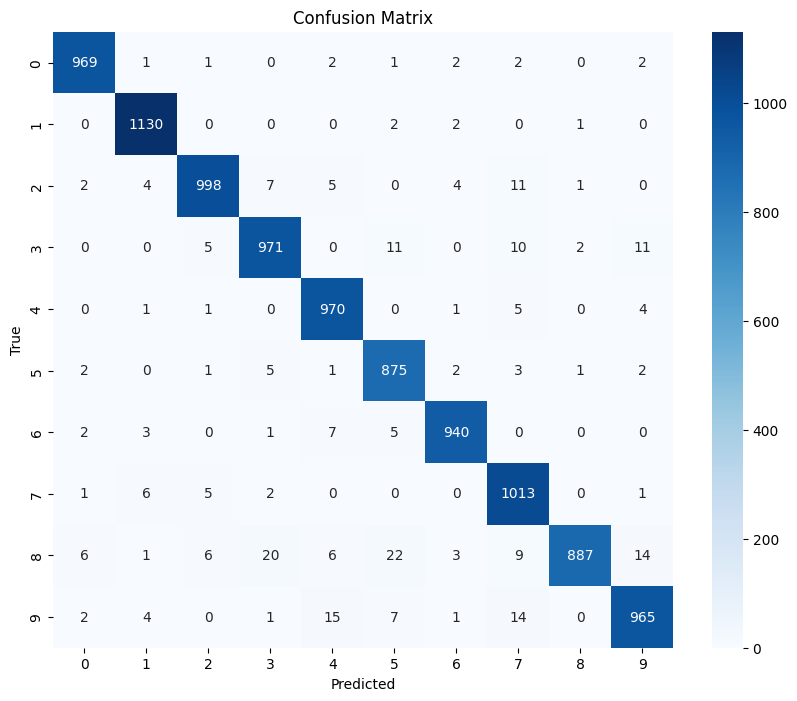

In [ ]:
# Define neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

# Constants
input_size = 784
hidden_sizes = [500, 250, 100]
output_size = 10
learning_rate = 0.0005
epochs = 15
alpha = 1e-5  # Regularization constant
train_losses = []
val_losses = []

# Create the neural network model
model = NeuralNetwork(input_size, hidden_sizes, output_size)

# Define loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)  # Adding L2 regularization

# Assuming you have defined train_loader and val_loader from the previously loaded MNIST dataset

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for batch_images, batch_labels in train_loader:
        batch_images = batch_images.view(-1, input_size)
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)

        # Adding L2 regularization term
        l2_reg = torch.tensor(0., dtype=torch.float)
        for param in model.parameters():
            l2_reg += torch.norm(param)

        loss += alpha * l2_reg

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {average_loss:.4f}")
    train_losses.append(average_loss)

# Validation loop
    total_val_loss = 0
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            batch_images = batch_images.view(-1, input_size)
            outputs = model(batch_images)
            loss = criterion(outputs, batch_labels)
            total_val_loss += loss.item()
        average_val_loss = total_val_loss / len(val_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {average_val_loss:.4f}")
        val_losses.append(average_val_loss)

# Testing loop
correct = 0
total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        batch_images = batch_images.view(-1, input_size)
        outputs = model(batch_images)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(batch_labels.numpy())
        predicted_labels.extend(predicted.numpy())

accuracy = (100 * correct / total)
print(f"Test Accuracy: {accuracy:.2f}%")
epochs = range(1, epochs + 1)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()

# Plot validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss vs Epochs')
plt.legend()
plt.show()

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Usefulness of Regularization:

**Preventing Overfitting**: Regularization, such as L2 regularization (weight decay) in the code, helps prevent overfitting by discouraging the model from fitting the training data too closely.

**Generalization**: Regularization encourages models to find smoother decision boundaries, leading to better generalization to new data.

**Improved Test Accuracy**: Regularized models tend to achieve higher test accuracy, indicating their ability to generalize well.

**Stability**: Regularization adds stability to training by reducing the chances of extreme weight values.

**Hyperparameter Tuning**: Regularization introduces hyperparameters that can be tuned to find the right balance between fitting training data and preventing overfitting.